# Figure SPM.5 - soil moisture map

See also [Figure 11.19 SM map](Figure_11.19_SM_map.ipynb) (same figure with slightly different layout for Chapter 11)

Author: Mathias Hauser

In [1]:
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import conf
from utils import computation, plot, save_figuredata
import data_tables


mpl.rcParams['figure.dpi'] = 200

In [2]:
warnings.filterwarnings("ignore", "invalid value encountered in reduce")

In [3]:
FIGURE_FOLDER = "Figure_SPM.5_SM_map"

plot.create_figure_folders(FIGURE_FOLDER, conf.cmip6)

## Load data

### global mean tas

In [4]:
c6_tas = conf.cmip6.load_post_all_concat(
    varn="tas",
    postprocess="global_mean"
)

 -- {'varn': 'tas', 'postprocess': 'global_mean', 'table': 'Amon', 'model': 'IITM-ESM', 'exp': 'ssp370', 'ens': 'r1i1p1f1', 'grid': 'gn', 'ensnumber': 0}: no data for 2099 - 2099 (1850..2098)


regional mean mrso

In [5]:
c6_mrso = conf.cmip6.load_post_all_concat(
    varn="mrso",
    postprocess="sm_annmean_regrid",
    anomaly="no_anom"
)

-- no data found for: {'exp': 'historical', 'varn': 'mrso', 'postprocess': 'sm_annmean_regrid', 'table': 'Lmon', 'model': 'CAMS-CSM1-0', 'ens': 'r2i1p1f1', 'grid': 'gn', 'ensnumber': 0}
-- no data found for: {'exp': 'historical', 'varn': 'mrso', 'postprocess': 'sm_annmean_regrid', 'table': 'Lmon', 'model': 'EC-Earth3', 'ens': 'r4i1p1f1', 'grid': 'gr', 'ensnumber': 0}
-- no data found for: {'exp': 'historical', 'varn': 'mrso', 'postprocess': 'sm_annmean_regrid', 'table': 'Lmon', 'model': 'GISS-E2-1-G', 'ens': 'r1i1p1f2', 'grid': 'gn', 'ensnumber': 0}
-- no data found for: {'exp': 'historical', 'varn': 'mrso', 'postprocess': 'sm_annmean_regrid', 'table': 'Lmon', 'model': 'CAMS-CSM1-0', 'ens': 'r2i1p1f1', 'grid': 'gn', 'ensnumber': 0}
-- no data found for: {'exp': 'historical', 'varn': 'mrso', 'postprocess': 'sm_annmean_regrid', 'table': 'Lmon', 'model': 'GISS-E2-1-G', 'ens': 'r1i1p1f2', 'grid': 'gn', 'ensnumber': 0}
-- no data found for: {'exp': 'historical', 'varn': 'mrso', 'postprocess

### Calculate anomalies (norm)

In [6]:
warming_levels = [1.5, 2.0, 4.0]

c6_mrso_norm = computation.process_datalist(
    computation.calc_anomaly, c6_mrso, start=1850, end=1900, how="norm"
)

c6_at_warming_mrso_norm = computation.at_warming_levels_list(
    c6_tas, c6_mrso_norm, warming_levels=warming_levels
)

## Plot

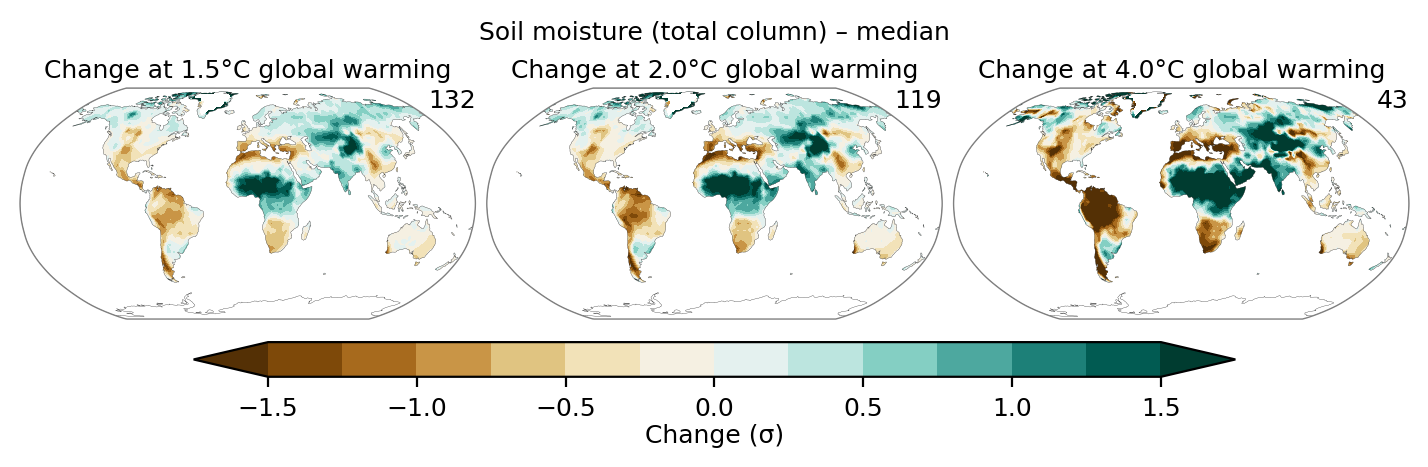

In [7]:
def plot_levels(levels, data, unit="Change (σ)", hatch_simple=None):

    return plot.at_warming_level_one(
        data,
        unit,
        "Soil moisture (total column)",
        levels=levels,
        average="median",
        mask_ocean=True,
        colorbar=True,
        robust=True,
        cmap="BrBG",
        skipna=True,
        plotfunc="contourf",
        add_coastlines=False,
        coastline_kws=dict(lw=0.1, color="k"),
        ocean_kws=dict(facecolor="w", edgecolor="k", zorder=1.1, lw=0.1),
        colorbar_kwargs=dict(
            extendfrac="auto",
        ),
        hatch_simple=hatch_simple,
    )


levels = np.arange(-1.5, 1.6, 0.25)
cbar = plot_levels(levels, c6_at_warming_mrso_norm)
cbar.set_ticks(levels[::2])

f = plt.gcf()
axes = f.axes[:3]

axes[0].set_title("", fontsize=9, pad=4, loc="left")
axes[1].set_title("", fontsize=9, pad=4, loc="left")
axes[2].set_title("", fontsize=9, pad=4, loc="left")

axes[0].set_title("Change at 1.5°C global warming", fontsize=9, pad=4)
axes[1].set_title("Change at 2.0°C global warming", fontsize=9, pad=4)
axes[2].set_title("Change at 4.0°C global warming", fontsize=9, pad=4)

fN = conf.cmip6.figure_filename("SM_tot_at_w_norm_simple_no_hatch", FIGURE_FOLDER)
plt.savefig(fN + ".pdf", dpi=300)
plt.savefig(fN + ".svg", dpi=300, facecolor="w")
plt.savefig(fN + ".png", dpi=300, transparent=False, facecolor="w")


# data tables
fN = conf.cmip6.figure_filename(
    "SM_tot_at_w_norm_simple_no_hatch", FIGURE_FOLDER, "data_tables"
)

dta_ = c6_at_warming_mrso_norm
data_tables.save_simulation_info_raw(fN + "_1.5_md_raw", dta_[0], panel="g")
data_tables.save_simulation_info_raw(fN + "_2.0_md_raw", dta_[1], panel="h")
data_tables.save_simulation_info_raw(fN + "_4.0_md_raw", dta_[2], panel="i")


# save figure data

sfd = save_figuredata.SaveFiguredata(
    chapter="Summary for Policymakers",
    figure="Figure SPM.6",
    units="std",
    varn=None,
)


for i, warming_level in enumerate([1.5, 2.0, 4.0]):

    fN = conf.cmip6.figure_filename(
        f"Figure_SPM.5_d{i + 1}_cmip6_SM_tot_change_at_",
        FIGURE_FOLDER,
        "figure_data",
        add_prefix=False,
    )

    da = dta_[i]
    da.attrs["long_name"] = "Total Soil Moisture Content"
    da.attrs["comment"] = "anomaly wrt 1850-1900"

    ds = sfd.map_panel(
        da=da,
        average="median",
        panel=None,
        warming_level=warming_level,
        hatch_simple=0.8,
    )
    ds.to_netcdf(fN + f"{warming_level:0.1f}C.nc")